# Fitting of ΔGs

In [1]:
import matplotlib.pyplot as plt
from pyhdx import PeptideMasterTable, read_dynamx, HDXMeasurement
from pyhdx.fitting import fit_rates_half_time_interpolate, fit_rates_weighted_average, fit_gibbs_global
from pathlib import Path
import numpy as np
from dask.distributed import Client

We load the sample SecB dataset, apply the control, and create an ``HDXMeasurement`` object.

In [2]:
fpath = Path() / '..' / '..' / 'tests' / 'test_data' / 'ecSecB_apo.csv'
data = read_dynamx(fpath)
master_table = PeptideMasterTable(data, drop_first=1, ignore_prolines=True)
master_table.set_control(('Full deuteration control', 0.167*60))
state_data = master_table.get_state('SecB WT apo')
hdxm = HDXMeasurement(state_data, temperature=303.15, pH=8.)

The first step is to obtain initial guesses for the observed rate of D-exchange.
By determining the timepoint at which 0.5 RFU (relative fractional uptake) is reached, and subsequently converting to rate,
a rough estimate of exchange rate per residue can be obtained. Here, RFU values are mapped from peptides to individual
residues by weighted averaging (where the weight is the inverse of peptide length)

In [3]:
fr_half_time = fit_rates_half_time_interpolate(hdxm)
fr_half_time.output

C:\Users\jhsmi\pp\PyHDX\pyhdx\models.py:615: RuntimeWarning: invalid value encountered in true_divide
  return self.Z / np.sum(self.Z, axis=0)[np.newaxis, :]


,rate
r_number,
10,0.054455
11,0.054455
12,0.035301
13,0.035301
14,0.035301
...,...
151,0.136605
152,0.136460
153,0.136460


A more accurate result can be obtained by fitting the per-residue/timepoint RFU values to a biexponential association curve.
This process is more time consuming and can optionally be processed in parallel by Dask.

In [4]:
client = Client()
fr_wt_avg = fit_rates_weighted_average(hdxm, client=client)

C:\Users\jhsmi\pp\PyHDX\pyhdx\models.py:615: RuntimeWarning: invalid value encountered in true_divide
  return self.Z / np.sum(self.Z, axis=0)[np.newaxis, :]


The return value is a ``KineticsFitResult`` object. This object has a list of models, intervals in withing the protein 
sequence to which these models apply, and their corresponding ``symfit`` fit result with parameter values. The effective 
exchange rate (units $s^{-1}$) can be extracted, as well as other fit parameters, from this object:

In [5]:
fr_wt_avg.output

C:\Users\jhsmi\pp\PyHDX\pyhdx\fit_models.py:224: RuntimeWarning: overflow encountered in exp
  t = np.exp(t_log)


,rate,k1,k2,r
r_number,,,,
10,0.064653,0.187059,0.001470,0.569994
11,0.064653,0.187059,0.001470,0.569994
12,0.055054,0.190494,0.001567,0.540090
13,0.055054,0.190494,0.001567,0.540090
14,0.055054,0.190494,0.001567,0.540090
...,...,...,...,...
151,0.828595,0.843758,0.000235,0.987547
152,2.768783,2.826372,0.000218,0.985887
153,2.768783,2.826372,0.000218,0.985887


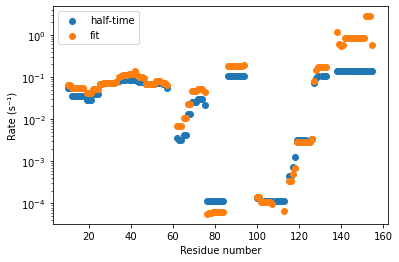

In [6]:
fig, ax = plt.subplots()
ax.set_yscale('log')
ax.scatter(fr_half_time.output.index, fr_half_time.output['rate'], label='half-time')
ax.scatter(fr_wt_avg.output.index, fr_wt_avg.output['rate'], label='fit')

ax.set_xlabel('Residue number')
ax.set_ylabel('Rate (s⁻¹)')
ax.legend()


We can now use the guessed rates to obtain guesses for the Gibbs free energy. Units of Gibbs free energy are J/mol.

In [7]:
gibbs_guess = hdxm.guess_deltaG(fr_wt_avg.output['rate'])
gibbs_guess

r_number
10     19765.736199
11     19301.237211
12     20635.398598
13     16860.539218
14     18951.649654
           ...     
151    11573.754525
152     9064.889494
153    11502.744868
154    11783.079284
155     1390.996025
Length: 146, dtype: float64

To perform the global fit (all peptides and timepoints) use ``fit_gibbs_global``. The number of epochs is set to 1000
here for demonstration but for actually fitting the values should be ~100000.

In [8]:
gibbs_result = fit_gibbs_global(hdxm, gibbs_guess, epochs=1000)
gibbs_output = gibbs_result.output
gibbs_output

100%|██████████| 1000/1000 [00:00<00:00, 1501.50it/s]


,sequence,_deltaG,deltaG,pfact,k_obs,covariance
r_number,,,,,,
10,T,19774.898348,19774.898348,2554.300985,0.064418,1.410011e+03
11,F,19352.119161,19352.119161,2159.861964,0.063361,1.404360e+03
12,Q,20666.254133,20666.254133,3637.937601,0.054384,7.865936e+02
13,I,16947.388328,16947.388328,831.924534,0.053192,7.820413e+02
14,Q,19010.515560,19010.515560,1886.108663,0.053784,7.841180e+02
...,...,...,...,...,...,...
151,E,11573.871708,11573.871708,98.675993,0.828557,1.161598e+04
152,H,9092.461907,9092.461907,36.868667,2.739456,5.330469e+07
153,Q,11502.744868,11502.744868,95.930376,2.768783,6.010136e+07


Along with ΔG the fit result returns covariances of ΔG and protection factors. The column `k_obs` is the observed rate of
exchange without taking into account the intrinsic exchange rate of each residue. If users want to obtain a result truly
independent of the intrinsic rate of exchange, the regularization value r1 should be set to zero (as this works on ΔG,
which is obtained by taking intrinsic rate of exchange into account) and users should provide their own initial guesses
for ΔG (as determination of initial guesses also uses intrinsic rates of exchange).

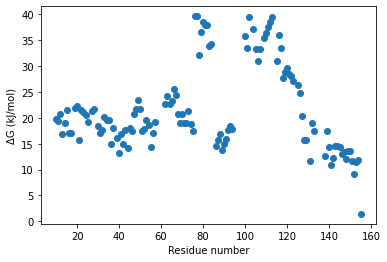

In [9]:
fig, ax = plt.subplots()
#ax.set_yscale('log')
ax.scatter(gibbs_output.index, gibbs_output['deltaG']*1e-3)
ax.set_xlabel('Residue number')
ax.set_ylabel('ΔG (kJ/mol)')
None


#### Number of epochs and overfitting

The returned fit result object also has information on the losses of each epoch of the fittng process. These are
stored as a `pd.DataFrame` in the `losses` attribute. During a successful fitting run, the losses should decrease sharply
and then flatten out.

<AxesSubplot:xlabel='epoch'>

<Figure size 432x288 with 0 Axes>

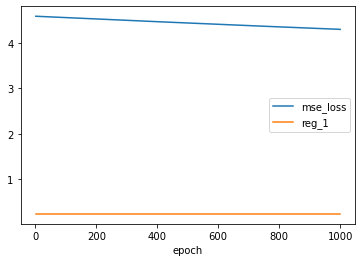

In [10]:
plt.figure()
gibbs_result.losses.plot()

In the figure above, `mse_loss` is the loss resulting from differences in calculated D-uptake and measured D-uptake
(mean squared error). The `reg_1` is the loss resulting from the regualizer.

If the losses do not decrease, this is likely due to a too low number of epochs or a too low learning rate.
Lets tune the fit parameters such that we obtain the desired result.

In [11]:
gibbs_result_updated = fit_gibbs_global(hdxm, gibbs_guess, epochs=40000)

100%|██████████| 40000/40000 [00:27<00:00, 1455.32it/s]


Text(0, 0.5, 'Loss')

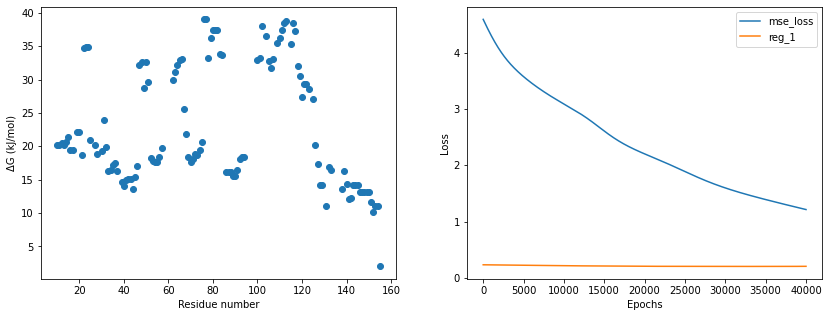

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
axes[0].scatter(gibbs_result_updated.output.index, gibbs_result_updated.output['deltaG']*1e-3)
axes[0].set_xlabel('Residue number')
axes[0].set_ylabel('ΔG (kJ/mol)')
gibbs_result_updated.losses.plot(ax=axes[1])
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')

By increasing the learning rate and the number of epochs, our result improves as the final MSE loss is lower.

With `stop_loss` at 1E-6 and `patience` at 50 (=default), the fitting will not terminate until for 50
epochs the progress (loss decrease) has been less than 1E-6.

The default value of `stop_loss`  is 1E-5. This will ensure optimization will stop when not enough progress is being made
and thereby prevent overfitting. 

Users can keep track of the ΔG values per epoch by using `Checkpoint` callbacks (See templates/04; advanced/experimental usage).


In [13]:
gibbs_result_updated = fit_gibbs_global(hdxm, gibbs_guess, epochs=60000, lr=1e5, stop_loss=1e-6, patience=50)


100%|██████████| 60000/60000 [00:43<00:00, 1384.86it/s]


In [14]:
gibbs_result_updated.regularization_percentage

57.09043167835134

Text(0, 0.5, 'Loss')

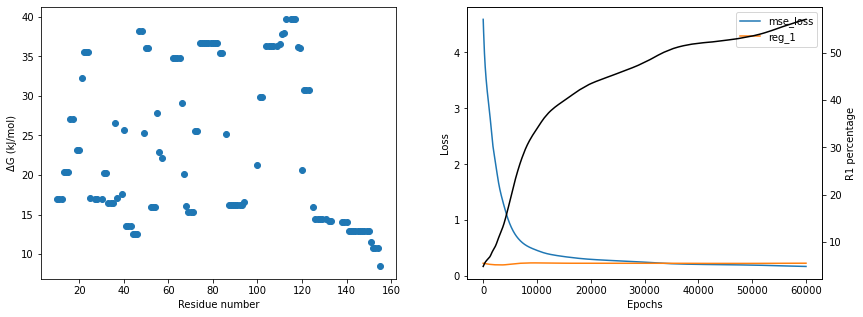

In [15]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
axes[0].scatter(gibbs_result_updated.output.index, gibbs_result_updated.output['deltaG']*1e-3)
axes[0].set_xlabel('Residue number')
axes[0].set_ylabel('ΔG (kJ/mol)')
gibbs_result_updated.losses.plot(ax=axes[1])
ax = axes[1].twinx()
ax.set_ylabel('R1 percentage')
percentage = 100 * gibbs_result_updated.losses['reg_1'] / (gibbs_result_updated.losses.sum(axis=1))
ax.plot(percentage, color='k')
axes[1].set_xlabel('Epochs')
axes[1].set_ylabel('Loss')

In [16]:
gibbs_result_updated.losses.sum(axis=1)

epoch
1        4.823331
2        4.821007
3        4.818298
4        4.815398
5        4.812404
           ...   
59996    0.406689
59997    0.406686
59998    0.406685
59999    0.406682
60000    0.406680
Length: 60000, dtype: float64

With these settings, the losses and the result become highly influenced by the regularizer `r1`, which dampens the result
and removes scatter in ΔG values.

#### The choice of regularizer value r1

The regularizer `r1` acts between subsequent residues minimizing differences between residues, unless data support
these differences. Higher values flatten out the ΔG values along residues, while lower values allow for more
variability.

The main function of `r1` is to mitigate the non-identifiability problem, where if multiple effective exchange rates (ΔG)
values are found within a peptide, it is impossible to know which rate should be assigned to which residue. Among the
possible choices, the regularizer `r1` will bias the result towards the choice of rate per residue assignment with the
least variability along residues.

The 'best' value of r1 depends on the size of the protein and the coverage, (the number/size of peptides). Below is an
example of the differences with regularizer values 0.1, 2 and 5.
In this dataset, despite the fact that for `r1=2` contribution `reg_1` is 50% of `total_loss`, most features in ΔG are
still resolved. In this case, it is recommended to try different values of `r1` (starting low and increasing) and find
the optimal value based on the ΔG result and fit metrics (Total mse loss at fit termination, $$\chi^2$$ per peptide
and fit curves per peptide (available in web interface)

In [17]:
r1_vals = [0.1, 2, 5]
results_dict = {}
for r1 in r1_vals:
    print(r1)
    result = fit_gibbs_global(hdxm, gibbs_guess, epochs=60000, lr=1e5, stop_loss=1e-5, patience=50, r1=r1)
    results_dict[r1] = result

100%|██████████| 60000/60000 [00:44<00:00, 1335.27it/s]


0.1
2
5


10.09466832487272
55.56463704204826
62.118677400826414


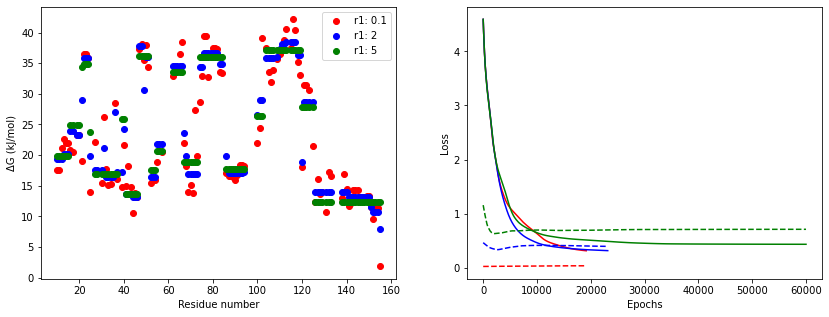

In [18]:
colors = iter(['r', 'b', 'g'])
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))
for k, v in results_dict.items():
    print(v.regularization_percentage)
    color = next(colors)
    axes[0].scatter(v.output.index, v.output['deltaG']*1e-3, color=color, label=f'r1: {k}')
    axes[0].set_xlabel('Residue number')
    axes[0].set_ylabel('ΔG (kJ/mol)')
    axes[1].plot(v.losses['mse_loss'], color=color)
    axes[1].plot(v.losses['reg_1'], color=color, linestyle='--')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Loss')

axes[0].legend()

#### Fit result covariances

Covariances on ΔG are estimated from the Hessian matrix $$\mathcal{H}$$. This matrix describes the local curvature of $$\chi^2$$
(sum of squared residuals) at each residue for the set of ΔG values obtained from the fit.
From the Hessian matrix, covariances are determined by taking the diagonal elements of the square root of the inverse of
the negative Hessian ($$\sqrt{\left|(-\mathcal{H})^{-1}_{ii}\right|}$$).

When these covariances are high, the optimization landscape is flat and therefore it presents a higher difficulty to finding
the exact minimum. High covariances frequently signal that the obtained ΔG values are at the extreme ends of the time
resolution of the experiment. In these regions, the ΔG values found represent an upper or lower limit and in order to
improve the ΔG range of the experiment shorter or longer timepoints need to be added.

Covariances are stored in the fit result and we can plot these on top of the ΔG values to see which regions are within the
range of the experiment.

Text(0, 0.5, 'ΔG (kJ/mol)')

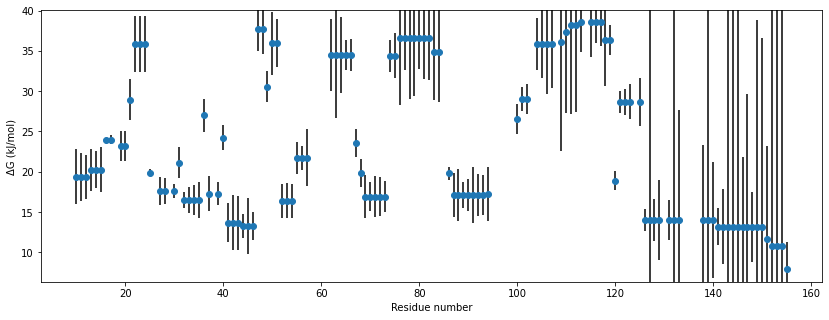

In [19]:

colors = iter(['r', 'b', 'g'])
fig, ax = plt.subplots(ncols=1, figsize=(14, 5))
v = results_dict[2]

ax.scatter(v.output.index, v.output['deltaG']*1e-3)
ylim = ax.get_ylim()
ax.errorbar(v.output.index, v.output['deltaG']*1e-3, yerr=v.output['covariance']*1e-3, linestyle='none', color='k', zorder=-1)
ax.set_ylim(*ylim)
ax.set_xlabel('Residue number')
ax.set_ylabel('ΔG (kJ/mol)')

In the graph above, covariances are high at SecB's disordered c-tail, highlighting that ΔG values obtained here represent
an upper limit where the actual ΔG values are likely to be lower. Likewise, high ΔG values also show high covariances which
can be improved by adding longer D-exposure datapoints.
Shorter D-exposure datapoints can be added in principle, but regions with low ΔG are more likely to exchagne via EX1 kinetics,
where PyHDX kinetics approximations break down.